Best to view on Google Drive
https://colab.research.google.com/drive/1Xz384s-fdh6bNzTGnvKkzeH0UHRrzHJY?usp=sharing

# TASK #1: UNDERSTAND THE PROBLEM STATEMENT AND BUSINESS CASE


<table>
  <tr><td>
    <img src="https://drive.google.com/uc?id=15eGnAbma5Q_j9CZZKi46Gh3-EpgSWYOV"
         alt="Fashion MNIST sprite"  width="1000">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1. Classifying disease using Deep Learning 
  </td></tr>
</table>


![alt text](https://drive.google.com/uc?id=19BuQ5m0xZWC7vQN4jX9lukmJ4aE0EkL8)

![alt text](https://drive.google.com/uc?id=10tbeSkGZ0xdHtqTGhYwHhb9PPURw0BfD)

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# TASK #2: IMPORT LIBRARIES AND DATASET

In [ ]:
# This is a custom dataset that contains covid-19 x-ray images, viral pneumonia x-ray images, bacterial pneumonia x-ray iamges and normal person x-ray images.
# Each class contains 133 images.
# Dataset Source:
# https://github.com/ieee8023/covid-chestxray-dataset 
# https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia


import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [ ]:
# You will need to mount your drive using the following commands:
# For more information regarding mounting, please check this out: https://stackoverflow.com/questions/46986398/import-data-into-google-colaboratory

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Specify training data directory
x_ray_directory = '/content/drive/My Drive/Lung xray/Dataset'

In [ ]:
# List the folders in the directory
os.listdir(x_ray_directory)

['0', '1', '2', '3']

In [ ]:
# Use image generator to generate tensor images data and normalize them
# Use 20% of the data for cross-validation  
image_generator = ImageDataGenerator(rescale = 1./255, validation_split=0.2)

In [ ]:
# Generate batches of 40 images
# Total number of images is 133*4 = 532 images
# Training is 428 (80%) and validation is 104 (20%)
# Perform shuffling and image resizing
train_generator = image_generator.flow_from_directory(batch_size=40, directory=x_ray_directory, shuffle=True, target_size=(256,256), class_mode='categorical', subset='training')


Found 428 images belonging to 4 classes.


In [ ]:
validation_generator = image_generator.flow_from_directory(batch_size=40, directory=x_ray_directory, shuffle=True, target_size=(256,256), class_mode='categorical', subset='validation')


Found 104 images belonging to 4 classes.


In [ ]:
# Generate a batch of 40 images and labels
train_images, train_label = next(train_generator)

In [ ]:
train_images.shape

(40, 256, 256, 3)

In [ ]:
train_label.shape

(40, 4)

In [ ]:
train_label

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]],

In [ ]:
# labels Translator 
label_names = {0:'Covid-19', 1: 'Normal', 2:'Viral Pneumonia', 3:'Bacterial Pneumonia'}

# TASK #3: VISUALIZE DATASET

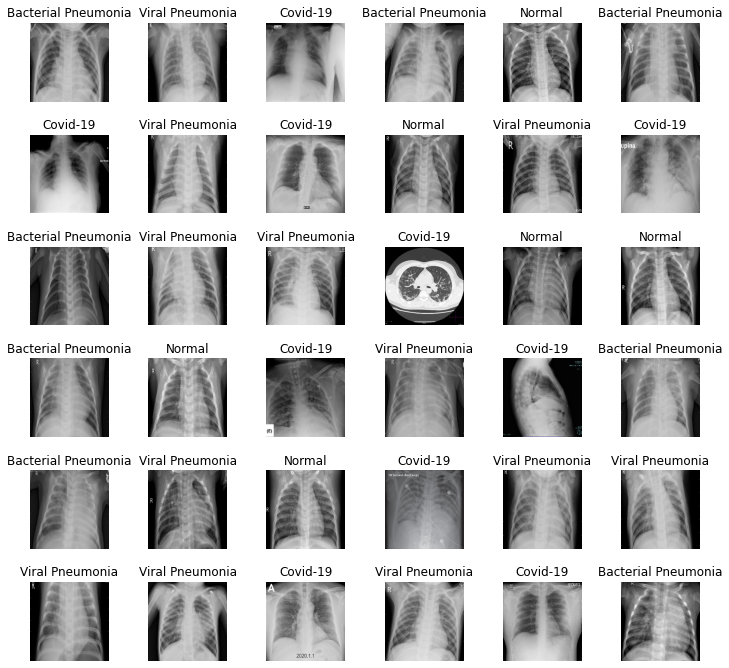

In [ ]:
L = 6
W = 6

fig, axes = plt.subplots(L, W, figsize=(12, 12))
axes = axes.ravel()

for i in np.arange(0,L*W):
  axes[i].imshow(train_images[i])
  axes[i].set_title(label_names[np.argmax(train_label[i])])
  axes[i].axis('off')

plt.subplots_adjust(wspace=0.5)

# TASK #4: UNDERSTAND THE THEORY AND INTUITION BEHIND CONVOLUTIONAL NEURAL NETWORKS

![alt text](https://drive.google.com/uc?id=176TJGdJtNZmX4J5QyeI8W_YS5f1gg5VS)

![alt text](https://drive.google.com/uc?id=1340UvqbXc-sy6cIuVg7ZbOwcga2JxfkP)

![alt text](https://drive.google.com/uc?id=1hngDlUf9JnwUhPII-Ah7KTtcvoeTI9m8)

![alt text](https://drive.google.com/uc?id=1nt8iX7H2LEhaWgGCi_NIb05DMQEoJVfI)

# TASK #5: UNDERSTAND THE THEORY AND INTUITION BEHIND TRANSFER LEARNING

![alt text](https://drive.google.com/uc?id=1Wnti2DSmA2qMRsgkD7Z_MJkmed0bJZTN)

![alt text](https://drive.google.com/uc?id=1Chdq0gdnHGYDDb50pMMtcTOZMr0u37Iz)

![alt text](https://drive.google.com/uc?id=14niGb232X6l8OD1dMT4a_u3fjh_jKuMS)

![alt text](https://drive.google.com/uc?id=1dye4zWALCDu8a1a-58HfZk4On4nVuizV)

# TASK #6: IMPORT MODEL WITH PRETRAINED WEIGHTS

In [ ]:
basemodel = ResNet50(include_top=False, input_tensor=Input(shape =(256,256,3)))

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
# freezing layers in the model
for layer in basemodel.layers[:-10]:
  layers.trainable = False

# TASK #7: BUILD AND TRAIN DEEP LEARNING MODEL

In [ ]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size=(4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256,activation='relu')(headmodel)
headmodel = Dropout(0.25)(headmodel)
headmodel = Dense(256,activation='relu')(headmodel)
headmodel = Dropout(0.2)(headmodel)
headmodel = Dense(4, activation='softmax')(headmodel)

In [ ]:
model = Model(inputs = basemodel.input, outputs = headmodel)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer= optimizers.RMSprop(learning_rate=1e-4), metrics=['accuracy'])

In [ ]:
# using early stopping to exit training if validation loss is not decreasing after certain number of epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=20)
# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath='weights.hdf5', verbose=1, save_best_only=True)

In [ ]:
train_generator = image_generator.flow_from_directory(batch_size=4, directory=x_ray_directory, shuffle=True, target_size=(256,256), class_mode='categorical', subset='training')
val_generator = image_generator.flow_from_directory(batch_size=4, directory=x_ray_directory, shuffle=True, target_size=(256,256), class_mode='categorical', subset='validation')

Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


In [ ]:
history = model.fit_generator(train_generator, epochs = 25, validation_data= val_generator, callbacks=[earlystopping,checkpointer])

Epoch 1/25
107/107 [==============================] - ETA: 0s - loss: 0.2643 - accuracy: 0.9112
Epoch 00001: val_loss did not improve from 6.07092
107/107 [==============================] - 15s 136ms/step - loss: 0.2643 - accuracy: 0.9112 - val_loss: 9.4919 - val_accuracy: 0.2596
Epoch 2/25
107/107 [==============================] - ETA: 0s - loss: 0.1827 - accuracy: 0.9509
Epoch 00002: val_loss did not improve from 6.07092
107/107 [==============================] - 13s 125ms/step - loss: 0.1827 - accuracy: 0.9509 - val_loss: 18.1578 - val_accuracy: 0.2596
Epoch 3/25
107/107 [==============================] - ETA: 0s - loss: 0.1267 - accuracy: 0.9836
Epoch 00003: val_loss improved from 6.07092 to 3.48782, saving model to weights.hdf5
107/107 [==============================] - 14s 135ms/step - loss: 0.1267 - accuracy: 0.9836 - val_loss: 3.4878 - val_accuracy: 0.5192
Epoch 4/25
107/107 [==============================] - ETA: 0s - loss: 0.0112 - accuracy: 0.9977
Epoch 00004: val_loss impr

# TASK #8: EVALUATE TRAINED DEEP LEARNING MODEL

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Text(0, 0.5, 'training accuracy')

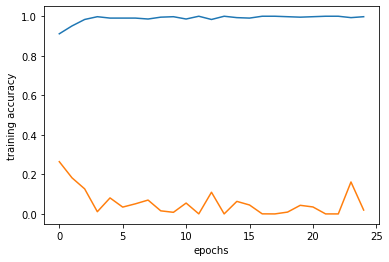

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.xlabel('epochs')
plt.ylabel('training accuracy')

Text(0, 0.5, 'val loss')

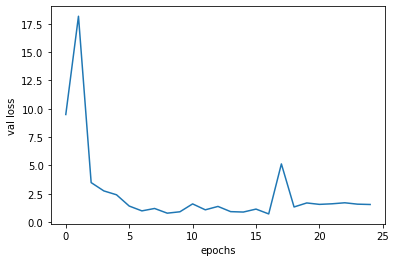

In [ ]:
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('val loss')

Text(0, 0.5, 'val accuracy')

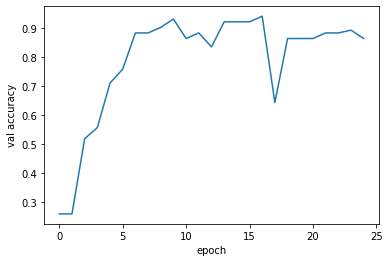

In [ ]:
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('val accuracy')

In [ ]:
test_directory = '/content/drive/My Drive/Lung xray/Test'

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_directory(batch_size=40, directory= test_directory, shuffle= True, target_size = (256,256), class_mode='categorical')

Found 40 images belonging to 4 classes.


In [ ]:
evaluate = model.evaluate_generator(test_generator, steps=test_generator.n//4, verbose=1)

Instructions for updating:
Please use Model.evaluate, which supports generators.
 1/10 [==>...........................] - 0s 29ms/step - loss: 4.7988 - accuracy: 0.8000


In [ ]:
print('Accuracy Test : {}'.format(evaluate[1]))

Accuracy Test : 0.800000011920929


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [ ]:
prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
  for item in os.listdir(os.path.join(test_directory,str(i))):
    img= cv2.imread(os.path.join(test_directory,str(i),item))
    img = cv2.resize(img,(256,256))
    image.append(img)
    img = img / 255
    img = img.reshape(-1,256,256,3)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

In [ ]:
score = accuracy_score(original,prediction)
print("Test Accuracy : {}".format(score))

Test Accuracy : 0.725


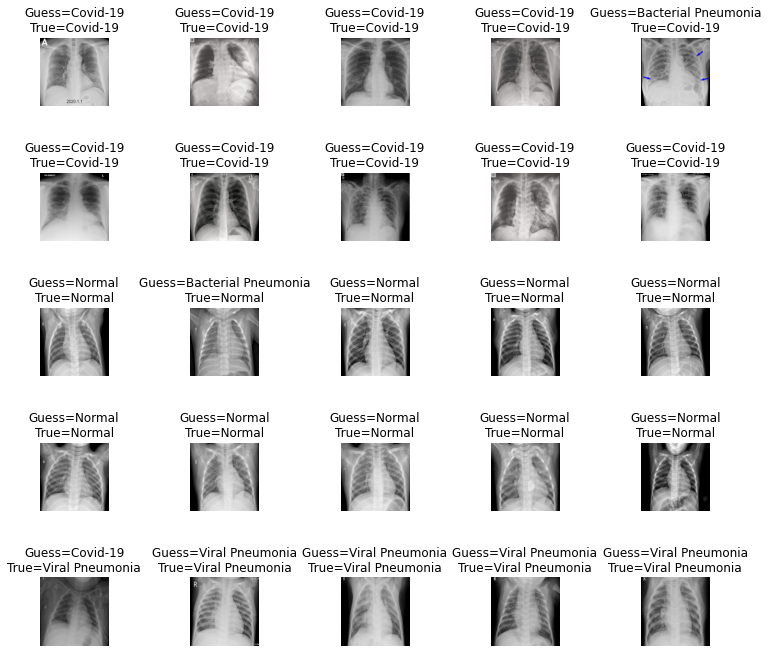

In [ ]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(image[i])
    axes[i].set_title('Guess={}\nTrue={}'.format(str(label_names[prediction[i]]), str(label_names[original[i]])))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1.2) 

In [ ]:
print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.64      0.90      0.75        10
           2       0.71      0.50      0.59        10
           3       0.67      0.60      0.63        10

    accuracy                           0.73        40
   macro avg       0.73      0.72      0.72        40
weighted avg       0.73      0.72      0.72        40



Text(0.5, 1.0, 'Confusion_matrix')

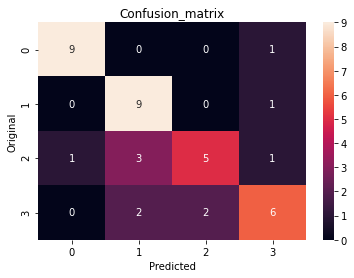

In [ ]:
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')